In [1]:
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget 
def PairwiseDistance_Calc(traj_data_t,box):
    '''
    Compute the pairwise distance betwen every pt
    diagnoal entries are replaced with large number because it is stupid to count yourself
    '''
 
    bond_vec = traj_data_t[:, None, :] - traj_data_t[None, :, :] #compute bond vector. The shape like [N,N,2]
    bond_vec =  bond_vec - np.rint(bond_vec/box)*box
    dist_matrix = np.sqrt(np.sum(bond_vec**2,axis=-1))
    np.fill_diagonal(dist_matrix, 1000000) #so that you don't count yourself


    return dist_matrix

def PairwiseDistance_Calc_fixed_surface(traj_data_t,reference_point,box,with_offset=True):
    '''
    Compute the pairwise distance betwen brush and a origin pt (y,z = 0,0)
    use this with brush_density_function_surface_fixed
    input: data.shape = [number_of_particles,2] where 2 is y and z coordinate
    with_offset means that there is an offset with the origin and the surface. with_offset = True when calculating density profile startin from the surface of the cylinder (6HB). The distance is 1 sigma from origin to honeycombe surface so -1 for all calculated distance
    '''
    dist_matrix = []
    for chn in range(len(traj_data_t)):
        bond_vec = traj_data_t[chn] - np.array(reference_point) #compute bond vector. The shape like [N,N,2]
        bond_vec =  bond_vec - np.rint(bond_vec/box)*box
        dist_matrix.append( np.sqrt(np.sum(bond_vec**2,axis=-1)))
        

    if with_offset:
        
        return np.array(dist_matrix)-1
    else:
        return np.array(dist_matrix)


def brush_density_function_surface_fixed(chain_position_data, box, dx=0.1,dl=7, bins=200,is_quasi_2D=True,count_backbone=False):
    '''
    input  position data [frame,particle,position]. This is used when we want to calculate the brush on a fixed rod, and we calculate agnostic to what chains are in the shell region
    This is super straightforward.
    '''
    if is_quasi_2D ==False:
        print("ERROR: NOT YET DEVELOPED")
    number_list = []
    number_TENSOR = []
    for frame in range(len(chain_position_data)):
        brush_in_shell_data = select_shell_region(chain_position_data[frame],have_two_shells=True)
        dist_from_surface = PairwiseDistance_Calc_fixed_surface(brush_in_shell_data[:,4:],[0,0],box) #calulate distance wrt origin (0,0)
        number_list = []
        for i in range(1, bins+1):
            min_range =  dx * (i - 1)
            max_range =  dx * i
            #find particle in the range defined by min and max range
            index = np.where((dist_from_surface>=min_range)&(dist_from_surface<=max_range)) #so that we are cacluating
            number_of_particle = len(dist_from_surface[index])
            density_factor = 2*np.pi*((min_range+max_range)/2)*dx*dl#2pi r dr dl # I pick mid range#I pick max_range, maybe median range also works 
            number_list.append(number_of_particle/density_factor)
        number_TENSOR.append(np.array(number_list))
    return np.array(number_TENSOR) #np.average(np.array(number_TENSOR),axis=0)

def select_shell_region(chain_position_data_t,have_two_shells=True):
    '''
    I fixed the backbone so that it will not flucutate. the region I selected is from x= -181.5 to -174.5 and from x= -17.5 to -10.5.
    '''
    assert have_two_shells, "NOT IMPLEMENTED"
    brush_in_first_region = chain_position_data_t[np.where(((chain_position_data_t[:,3]>=-181.5)&(chain_position_data_t[:,3]<=-174.5)))]
    brush_in_sec_region = chain_position_data_t[np.where(((chain_position_data_t[:,3]>=-17.5)&(chain_position_data_t[:,3]<=-10.5)))]
    brush_in_shell_data = np.concatenate((brush_in_first_region,brush_in_sec_region))
    
    return brush_in_shell_data

In [2]:
def Process_LAMMPS_Data_Silicification(file="product.lammpstrj"):
    '''
    extract position data of particle type 3 ()and type 6
    '''
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      # We read the number of particles, the system box, and the
      # particle positions into 3 separate arrays.
      N = int(np.genfromtxt(file, skip_header=3, max_rows=1))
      box_data = np.genfromtxt(file, skip_header=5, max_rows=3)
      data = np.genfromtxt(file, skip_header=9, invalid_raise=False)
    # Remove the unwanted text rows
    data = data[~np.isnan(data).all(axis=1)].reshape(-1, N, 6)
    data_type3 = data[data[:,:,2]==3]
    data_type3 = data_type3.reshape(len(data),int(data_type3.size/(len(data)*6)),6)
    data_type6 = data[data[:,:,2]==6]
    data_type6 = data_type6.reshape(len(data),int(data_type6.size/(len(data)*6)),6)

    box = box_data[0][1]-box_data[0][0]
    return data_type3,data_type6,box


In [4]:
##Parameter for density function###
bins = 200
dx = 1.2
range_end = bins*dx*0.5+ dx*0.5#sigma to nm = 0.5 
range_start = dx*0.5
range_step = dx*0.5
###################################


Distance_r = np.arange(range_start, range_end, range_step)
for i in [111,222,333]: #random sample id
    #file = 'Final_test/ssDNA/{}/product.lammpstrj'.format(i)
    file = '/home/popo/Code file/Condensation_analysis/Charge_Density_analysis/ssDNA/product_{}.lammpstrj'.format(i)
    _, data_type6,box = Process_LAMMPS_Data_Silicification(file)
    brush = brush_density_function_surface_fixed(data_type6,box, dx=dx,dl=7, bins=200,is_quasi_2D=True)

    saved_density = np.average(brush,axis=0)
    
    df = pd.DataFrame({'Y (nm^3)':saved_density, 'X':Distance_r})
    df.to_csv('brush_density_ssDNA_fixed{}.csv'.format(i), index=False)
    #np.save('brush_density_ssDNA{}'.format(i),saved_density)
    
    file = '/home/popo/Code file/Condensation_analysis/Charge_Density_analysis/hairpin/product_{}.lammpstrj'.format(i)
    _, data_type6,box = Process_LAMMPS_Data_Silicification(file)
    brush = brush_density_function_surface_fixed(data_type6,box, dx=dx,dl=7, bins=200,is_quasi_2D=True)
    saved_density = np.average(brush,axis=0)
    df = pd.DataFrame({'Y (nm^3)':saved_density, 'X':Distance_r}) 
    df.to_csv('brush_density_dsDNA_fixed{}.csv'.format(i), index=False)

In [5]:
csv_files = ['brush_density_ssDNA_fixed111.csv', 'brush_density_ssDNA_fixed222.csv', 'brush_density_ssDNA_fixed333.csv',\
            'brush_density_dsDNA_fixed111.csv', 'brush_density_dsDNA_fixed222.csv', 'brush_density_dsDNA_fixed333.csv']

data_frames = []
for index,file_name in enumerate(csv_files):
    df = pd.read_csv(file_name)
    df['Source'] = 'Sample {}'.format(file_name[-5]) #so would be Sample 1 Sample 2
    if file_name[-18:-16]=='ss':
        df['Type'] = '6HB-5*/17/5*'
        charge_perpoint=3.2 #ssDNA = 3.2e
        unit_charge_per_volume = 1/(5.3*8)#unit convert to real unit e/nm^3
        df['Y (nm^3)'] = df['Y (nm^3)'].apply(lambda x: x*charge_perpoint*unit_charge_per_volume) #convert to charge per volume
        
    else:
        df['Type'] = '6HB-5*/17/5*-DS'
        charge_perpoint=11.8 #dsDNA = 11.8e
        unit_charge_per_volume = 1/(5.3*8)#unit convert to real unit e/nm^3
        df['Y (nm^3)'] = df['Y (nm^3)'].apply(lambda x: x*charge_perpoint*unit_charge_per_volume) #convert to charge per volume

    data_frames.append(df)

concatenated_df = pd.concat(data_frames, ignore_index=True)
concatenated_df.head()


,Y (nm^3),X,Source,Type
0,0.028607,0.6,Sample 1,6HB-5*/17/5*
1,0.009905,1.2,Sample 1,6HB-5*/17/5*
2,0.009854,1.8,Sample 1,6HB-5*/17/5*
3,0.008742,2.4,Sample 1,6HB-5*/17/5*
4,0.007209,3.0,Sample 1,6HB-5*/17/5*


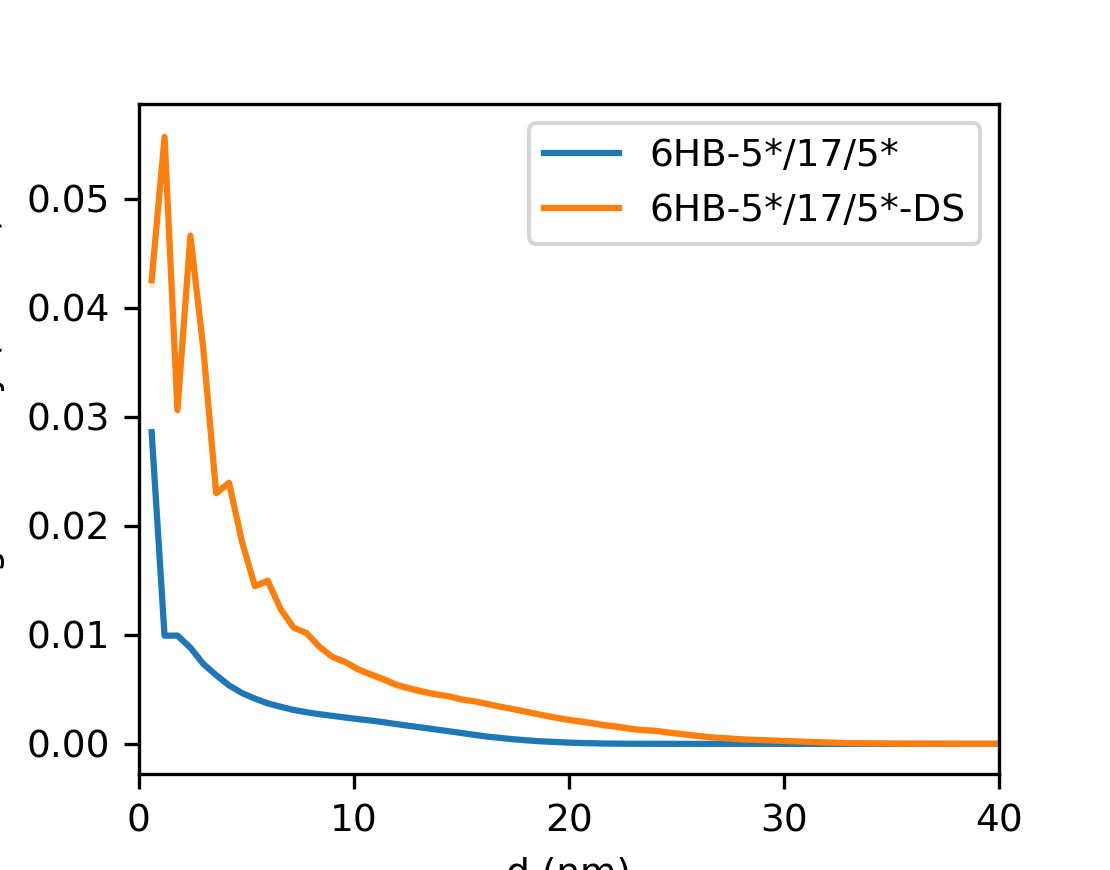

In [7]:
import seaborn as sns
import pandas as pd
import matplotlib as mpl
from matplotlib.pyplot import figure
plt.close()
plt.clf()
figure(figsize=(3.7, 2.9), dpi=300)
mpl.rcParams['pdf.fonttype'] = 42 #To make this editable in Adobe
mpl.rcParams.update({'font.size': 9})
mpl.rcParams['lines.markeredgewidth'] = 1
ax = sns.lineplot(data=concatenated_df, x="X", y="Y (nm^3)",
                 hue="Type",style="Type",errorbar='se',dashes=False)
handles,labels = ax.get_legend_handles_labels()
plt.legend(handles,labels,title='', loc='upper left')
ax.set(xlim=(0, 40))
ax.legend(markerscale=1)
#specfiy axis labels
ax.set(xlabel=r'd (nm)',
           ylabel=r'Charge Density ($e/\mathrm{nm}^3$)',
           title='')
plt.savefig("brush_charge_density.pdf",bbox_inches='tight',dpi=300)
plt.show()



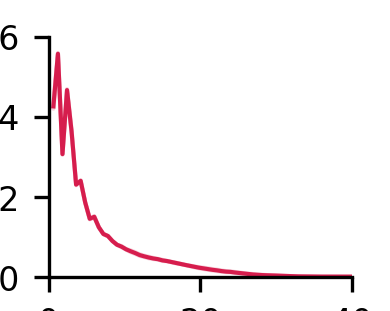

In [28]:
# plot DS and SS individually 
DS_df = concatenated_df.loc[concatenated_df['Type']=='6HB-5*/17/5*-DS']
#determine figure size
fig_w = 94.1565*0.013834867007874
fig_h = 75.1503*0.013834867007874#71.1503*0.013834867007874

plt.close()
plt.clf()
figure(figsize=(fig_w, fig_h), dpi=300)
mpl.rcParams['pdf.fonttype'] = 42 #To make this editable in Adobe
mpl.rcParams.update({'font.size': 8})
mpl.rcParams['lines.markeredgewidth'] = 1
ax = sns.lineplot(data=DS_df, x="X", y="Y (nm^3)",palette=['#D61D4D'],
                 hue="Type",style="Type",errorbar='se',dashes=False,linewidth=1)
ax.set(xlim=(0, 40))
ax.set(ylim=(0, 0.06))
#ax.legend(markerscale=1)
#specfiy axis labels
ax.get_legend().remove()
ax.set(xlabel=r'r (nm)',
           ylabel='Charge Density' '\n' r'($e/\mathrm{nm}^3$)',
           title='')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.axis('off')
plt.savefig('DS_charge_density.pdf', bbox_inches='tight', transparent=True, pad_inches=0,dpi=600)

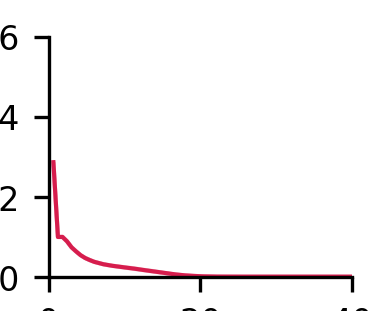

In [29]:
# plot DS and SS individually 
DS_df = concatenated_df.loc[concatenated_df['Type']=='6HB-5*/17/5*']
#determine figure size
fig_w = 94.1565*0.013834867007874
fig_h = 75.1503*0.013834867007874#71.1503*0.013834867007874

plt.close()
plt.clf()
figure(figsize=(fig_w, fig_h), dpi=300)
mpl.rcParams['pdf.fonttype'] = 42 #To make this editable in Adobe
mpl.rcParams.update({'font.size': 8})
mpl.rcParams['lines.markeredgewidth'] = 1
ax = sns.lineplot(data=DS_df, x="X", y="Y (nm^3)",palette=['#D61D4D'],
                 hue="Type",style="Type",errorbar='se',dashes=False,linewidth=1)
ax.set(xlim=(0, 40))
ax.set(ylim=(0, 0.06))
#ax.legend(markerscale=1)
#specfiy axis labels
ax.get_legend().remove()
ax.set(xlabel=r'r (nm)',
           ylabel='Charge Density' '\n' r'($e/\mathrm{nm}^3$)',
           title='')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.axis('off')
plt.savefig('SS_charge_density.pdf', bbox_inches='tight', transparent=True, pad_inches=0,dpi=600)